# Analyzing ALPS... Visually

In [1]:
import sys
sys.path.insert(0, '../')

In [2]:
import torch
import datasets
from transformers import (
    BertTokenizer, 
    BertForSequenceClassification
)
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from ignite.contrib.handlers.tqdm_logger import ProgressBar
from src.active.strategies import Alps
from scripts.al_seq_cls import prepare_seq_cls_datasets

## Preparation

In [3]:
# load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# load and prepare dataset
ds = datasets.load_dataset('trec', split={'train': 'train'})
ds = prepare_seq_cls_datasets(ds, tokenizer, max_length=64, label_column='label-coarse')
pool = ds['train']
num_labels = len(pool.info.features['labels'].names)

Using custom data configuration default
Reusing dataset trec (/home/stud/doll0/.cache/huggingface/datasets/trec/default/1.1.0/751da1ab101b8d297a3d6e9c79ee9b0173ff94c4497b75677b59b61d5467a9b9)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/stud/doll0/.cache/huggingface/datasets/trec/default/1.1.0/751da1ab101b8d297a3d6e9c79ee9b0173ff94c4497b75677b59b61d5467a9b9/cache-ff6db2d8c5459361.arrow


In [4]:
# load model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

## ALPS (MLM = 15%)

In [5]:
# create strategy and attach progress bar
strategy = Alps(model, mlm_prob=0.15)
ProgressBar().attach(strategy)
# query strategy
_ = strategy.query(pool, query_size=25, batch_size=16)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[1/341]   0%|           [00:00<?]

### Checking K-Means Clusters

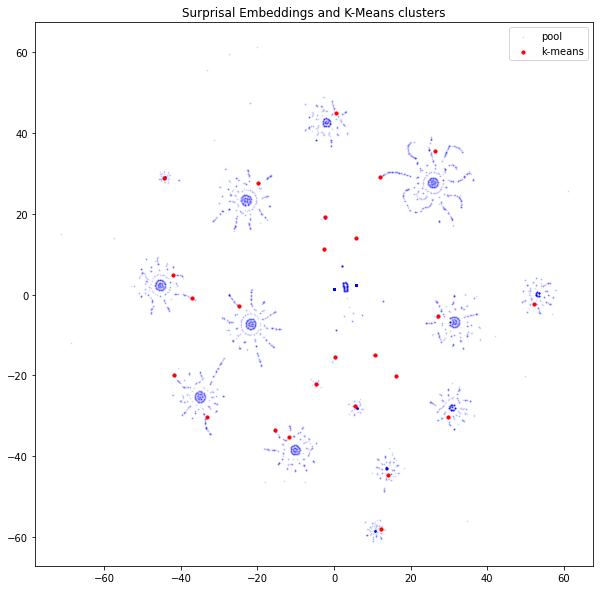

In [6]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
# cluster
kmeans = KMeans(n_clusters=25)
kmeans = kmeans.fit(strategy.output)
centers = kmeans.cluster_centers_
# dimensionality reduction
tsne = TSNE(
    n_components=2,
    perplexity=50,
    learning_rate='auto',
    init='random'
)
# concat embeddings and clusters for tsne
n = strategy.output.size(0)
XC = np.concatenate([strategy.output.numpy(), centers], axis=0)
# fit and transform
XC = tsne.fit_transform(X=XC)
X, C = XC[:n], XC[n:]
# plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(X[:, 0], X[:, 1], s=1.0, color='blue', alpha=0.1)
ax.scatter(C[:, 0], C[:, 1], s=10.0, color='red', alpha=1.0)
ax.legend(['pool', 'k-means'])
ax.set(title="Surprisal Embeddings and K-Means clusters")
plt.show()

### Plot Embeddings

In [7]:
# plot strategy embeddings and selection
idx = strategy.selected_indices
# dimensionality reduction
X = TSNE(
    n_components=2,
    perplexity=50,
    learning_rate='auto',
    init='random'
).fit_transform(
    X=strategy.output
)

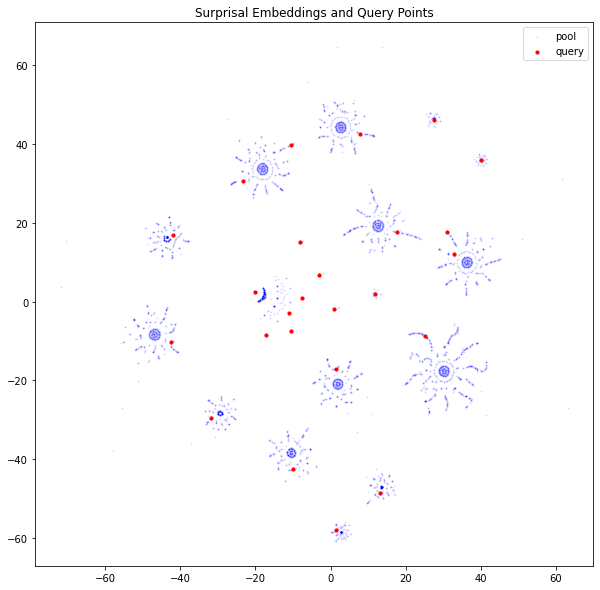

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(X[:, 0], X[:, 1], s=1.0, color='blue', alpha=0.1)
ax.scatter(X[idx, 0], X[idx, 1], s=10.0, color='red', alpha=1.0)
ax.legend(['pool', 'query'])
ax.set(title="Surprisal Embeddings and Query Points")
plt.show()

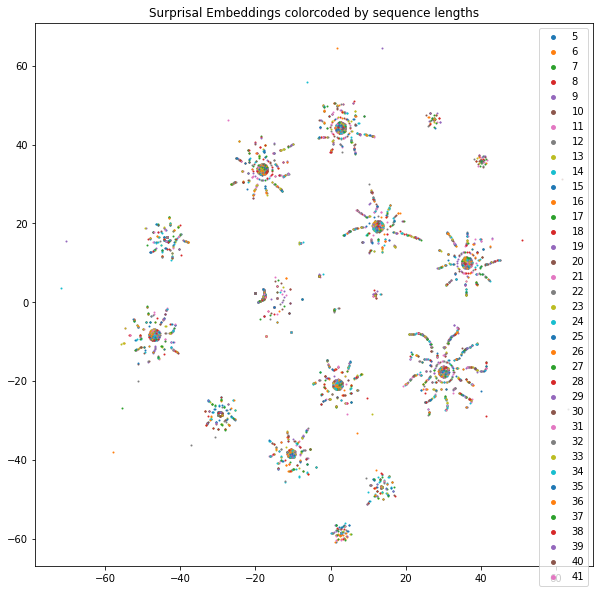

In [9]:
lengths = pool['attention_mask'].sum(dim=-1)
uniques = lengths.unique()
# create figure
fig, ax = plt.subplots(figsize=(10, 10))
# plot
for l in uniques:
    mask = (lengths == l)
    ax.scatter(X[mask, 0], X[mask, 1], 
        s=1.0, 
        alpha=1.0,
        color=None if l > 0 else 'red',
        label=l.item()
    )
# set legend
leg = ax.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    lh.set_sizes([15])
ax.set(title="Surprisal Embeddings colorcoded by sequence lengths")
# all done
plt.show()

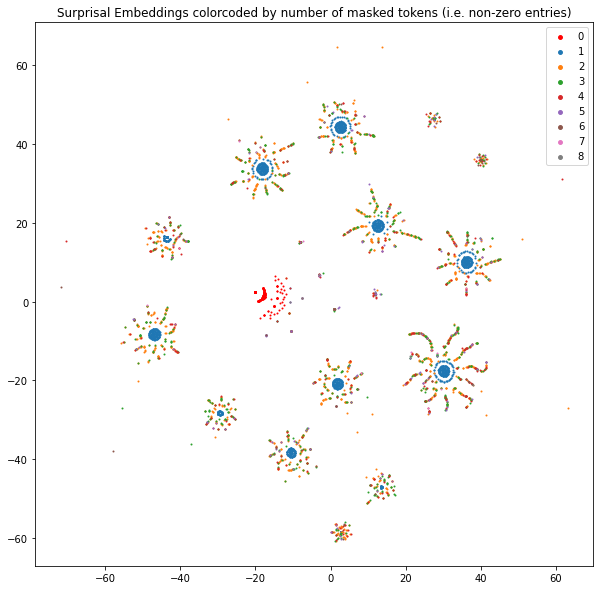

In [10]:
embeds = strategy.output
lengths = (embeds > 0).sum(dim=-1)
uniques = lengths.unique()
# create figure
fig, ax = plt.subplots(figsize=(10, 10))
# plot
for l in uniques:
    mask = (lengths == l)
    ax.scatter(X[mask, 0], X[mask, 1], 
        s=1.0, 
        alpha=1.0,
        color=None if l > 0 else 'red',
        label=l.item()
    )
# set legend
leg = ax.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    lh.set_sizes([15])
ax.set(title="Surprisal Embeddings colorcoded by number of masked tokens (i.e. non-zero entries)")
# all done
plt.show()

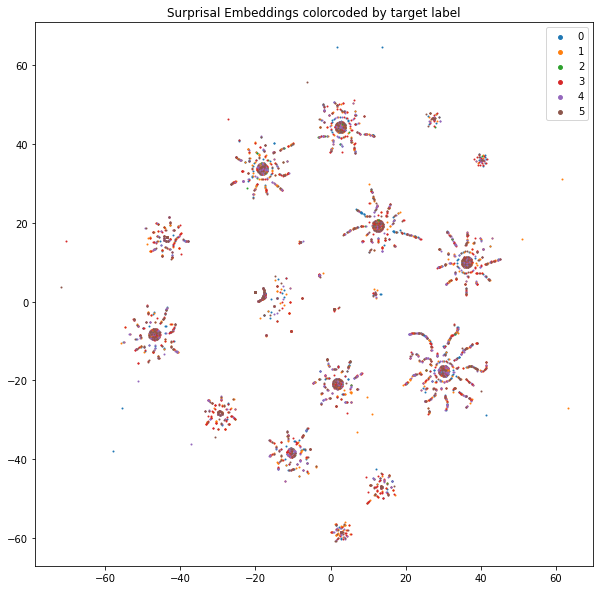

In [11]:
labels = pool['labels']
# create figure
fig, ax = plt.subplots(figsize=(10, 10))
# plot
for i in range(num_labels):
    mask = (labels == i)
    ax.scatter(X[mask, 0], X[mask, 1], 
        s=1.0, 
        alpha=1.0,
        label=i
    )
# set legend
leg = ax.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    lh.set_sizes([15])
ax.set(title="Surprisal Embeddings colorcoded by target label")
# all done
plt.show()

## ALPS (MLM = 100%)

In [18]:
# create strategy and attach progress bar
strategy = Alps(model, mlm_prob=1.0)
ProgressBar().attach(strategy)
# query strategy
_ = strategy.query(pool, query_size=25, batch_size=16)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[1/341]   0%|           [00:00<?]

### Checking K-Means Clusters

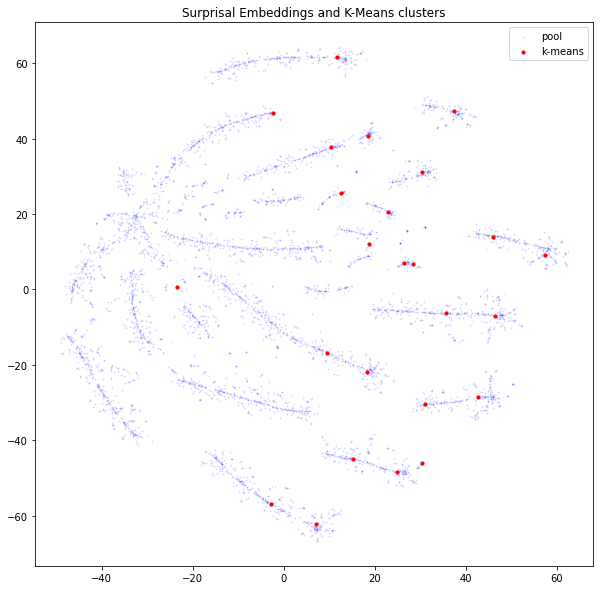

In [19]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
# cluster
kmeans = KMeans(n_clusters=25)
kmeans = kmeans.fit(strategy.output)
centers = kmeans.cluster_centers_
# dimensionality reduction
tsne = TSNE(
    n_components=2,
    perplexity=50,
    learning_rate='auto',
    init='random'
)
# concat embeddings and clusters for tsne
n = strategy.output.size(0)
XC = np.concatenate([strategy.output.numpy(), centers], axis=0)
# fit and transform
XC = tsne.fit_transform(X=XC)
X, C = XC[:n], XC[n:]
# plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(X[:, 0], X[:, 1], s=1.0, color='blue', alpha=0.1)
ax.scatter(C[:, 0], C[:, 1], s=10.0, color='red', alpha=1.0)
ax.legend(['pool', 'k-means'])
ax.set(title="Surprisal Embeddings and K-Means clusters")
plt.show()

### Plot Embeddings

In [20]:
# plot strategy embeddings and selection
idx = strategy.selected_indices
# dimensionality reduction
X = TSNE(
    n_components=2,
    perplexity=50,
    learning_rate='auto',
    init='random'
).fit_transform(
    X=strategy.output
)

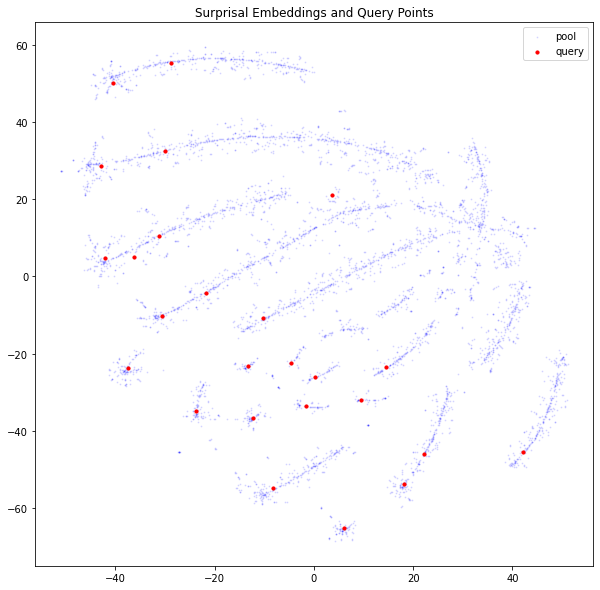

In [21]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(X[:, 0], X[:, 1], s=1.0, color='blue', alpha=0.1)
ax.scatter(X[idx, 0], X[idx, 1], s=10.0, color='red', alpha=1.0)
ax.legend(['pool', 'query'])
ax.set(title="Surprisal Embeddings and Query Points")
plt.show()

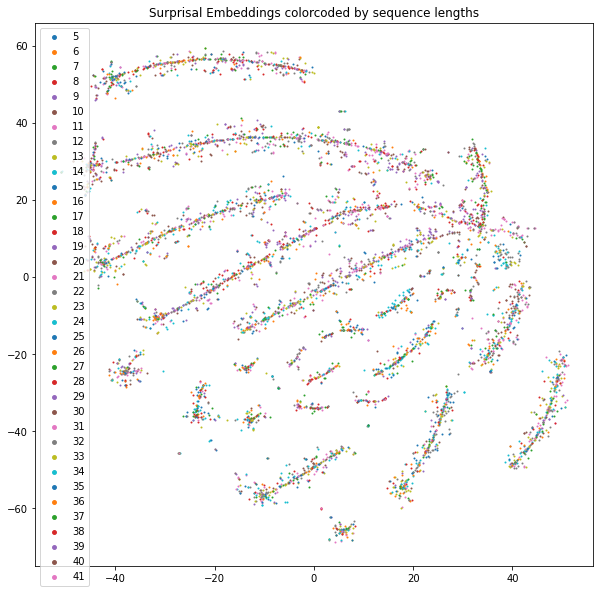

In [22]:
lengths = pool['attention_mask'].sum(dim=-1)
uniques = lengths.unique()
# create figure
fig, ax = plt.subplots(figsize=(10, 10))
# plot
for l in uniques:
    mask = (lengths == l)
    ax.scatter(X[mask, 0], X[mask, 1], 
        s=1.0, 
        alpha=1.0,
        color=None if l > 0 else 'red',
        label=l.item()
    )
# set legend
leg = ax.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    lh.set_sizes([15])
ax.set(title="Surprisal Embeddings colorcoded by sequence lengths")
# all done
plt.show()

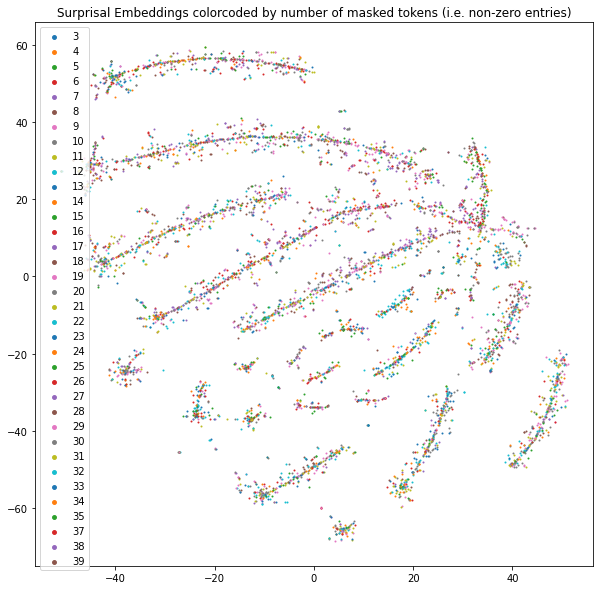

In [23]:
embeds = strategy.output
lengths = (embeds > 0).sum(dim=-1)
uniques = lengths.unique()
# create figure
fig, ax = plt.subplots(figsize=(10, 10))
# plot
for l in uniques:
    mask = (lengths == l)
    ax.scatter(X[mask, 0], X[mask, 1], 
        s=1.0, 
        alpha=1.0,
        color=None if l > 0 else 'red',
        label=l.item()
    )
# set legend
leg = ax.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    lh.set_sizes([15])
ax.set(title="Surprisal Embeddings colorcoded by number of masked tokens (i.e. non-zero entries)")
# all done
plt.show()

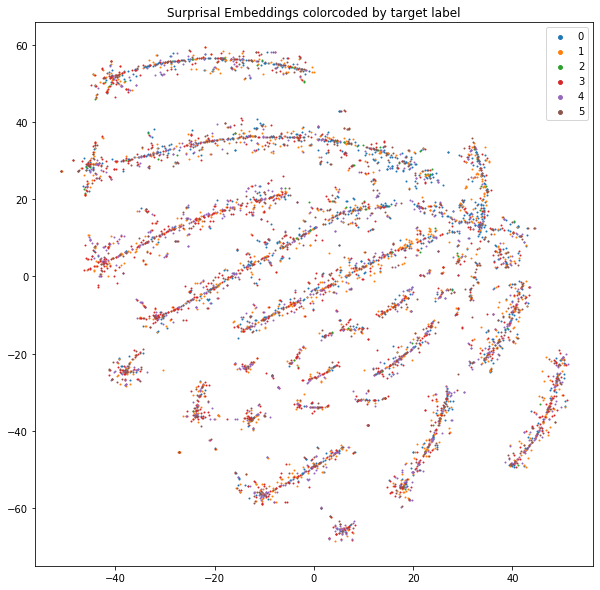

In [24]:
labels = pool['labels']
# create figure
fig, ax = plt.subplots(figsize=(10, 10))
# plot
for i in range(num_labels):
    mask = (labels == i)
    ax.scatter(X[mask, 0], X[mask, 1], 
        s=1.0, 
        alpha=1.0,
        label=i
    )
# set legend
leg = ax.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    lh.set_sizes([15])
ax.set(title="Surprisal Embeddings colorcoded by target label")
# all done
plt.show()

## Un-normalized ALPS

In [12]:
# create strategy and attach progress bar
strategy = Alps(model, mlm_prob=0.15, normalize=False)
ProgressBar().attach(strategy)
# query strategy
_ = strategy.query(pool, query_size=25, batch_size=16)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[1/341]   0%|           [00:00<?]

In [13]:
# plot strategy embeddings and selection
idx = strategy.selected_indices
# dimensionality reduction
X = TSNE(
    n_components=2,
    perplexity=50,
    learning_rate='auto',
    init='random'
).fit_transform(
    X=strategy.output
)

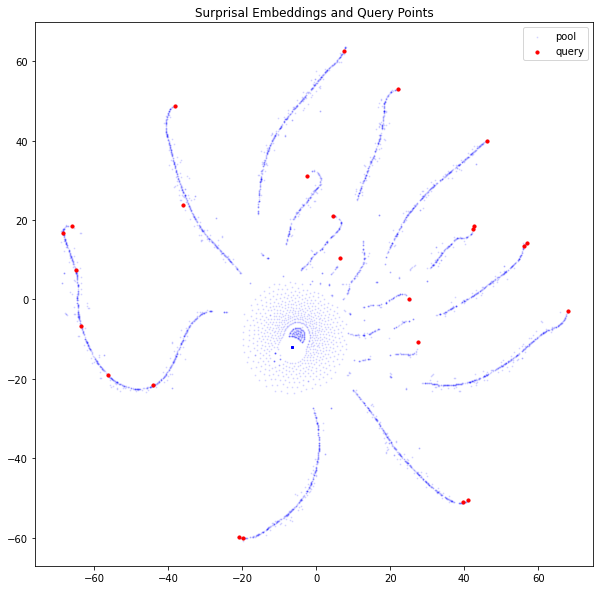

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(X[:, 0], X[:, 1], s=1.0, color='blue', alpha=0.1)
ax.scatter(X[idx, 0], X[idx, 1], s=10.0, color='red', alpha=1.0)
ax.legend(['pool', 'query'])
ax.set(title="Surprisal Embeddings and Query Points")
plt.show()

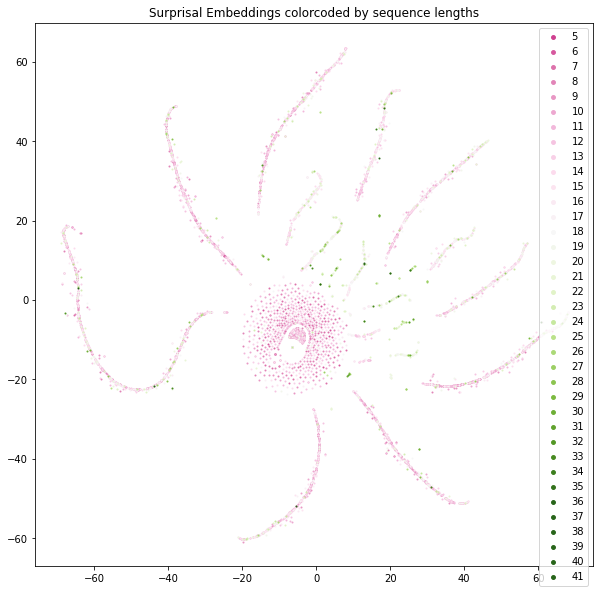

In [15]:
lengths = pool['attention_mask'].sum(dim=-1)
uniques = lengths.unique()
# create figure
fig, ax = plt.subplots(figsize=(10, 10))
cmap = plt.cm.get_cmap('PiYG', len(uniques))
# plot
for l in uniques:
    mask = (lengths == l)
    ax.scatter(X[mask, 0], X[mask, 1], 
        s=1.0, 
        alpha=1.0,
        color=cmap(l.item()),
        label=l.item()
    )
# set legend
leg = ax.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    lh.set_sizes([15])
ax.set(title="Surprisal Embeddings colorcoded by sequence lengths")
# all done
plt.show()

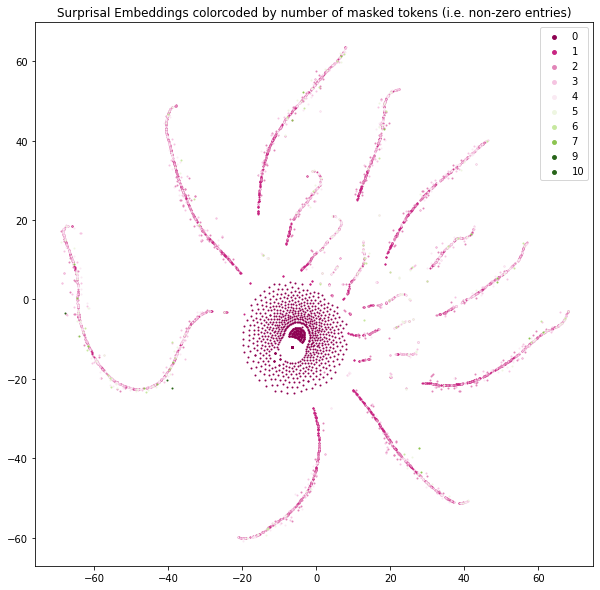

In [16]:
embeds = strategy.output
lengths = (embeds > 0).sum(dim=-1)
uniques = lengths.unique()
# create figure
fig, ax = plt.subplots(figsize=(10, 10))
cmap = plt.cm.get_cmap('PiYG', len(uniques))
# plot
for l in uniques:
    mask = (lengths == l)
    ax.scatter(X[mask, 0], X[mask, 1], 
        s=1.0, 
        alpha=1.0,
        color=cmap(l.item()),
        label=l.item()
    )
# set legend
leg = ax.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    lh.set_sizes([15])
ax.set(title="Surprisal Embeddings colorcoded by number of masked tokens (i.e. non-zero entries)")
# all done
plt.show()

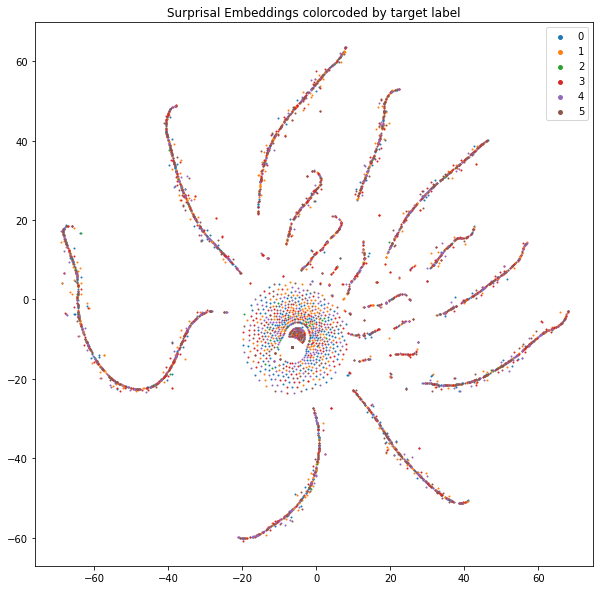

In [17]:
labels = pool['labels']
# create figure
fig, ax = plt.subplots(figsize=(10, 10))
# plot
for i in range(num_labels):
    mask = (labels == i)
    ax.scatter(X[mask, 0], X[mask, 1], 
        s=1.0, 
        alpha=1.0,
        label=i
    )
# set legend
leg = ax.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    lh.set_sizes([15])
ax.set(title="Surprisal Embeddings colorcoded by target label")
# all done
plt.show()